In [2]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

import fnmatch
import os
import pandas as pd
import geopandas as gpd

from datacube_stats.statistics import GeoMedian
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.helpers import write_geotiff
import xarray as xr

#get the DEA version of the plotting functions
import sys
sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/dea-notebooks/10_Scripts'))
import DEAPlotting
import DEADataHandling


import datacube
dc = datacube.Datacube(app='load_sentinel_example')

In [25]:
time = ('2018-02-25','2018-05-25')
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1']
resolution = (-10,10)

query = {
        #'x': x,
        #'y': y,
        'lat': (-40.188, -40.214),
        'lon': (148.228, 148.268),
        #'crs': 'EPSG:3577',
        'output_crs': 'EPSG:3577',
        'resolution': resolution, #(-20, 20),
        #'measurements': ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1'],
        'time': time #('2017-01-01', '2017-02-01')
        }

#canberra_cm = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)


data10 = DEADataHandling.load_clearsentinel2(dc=dc, query=query,
                                                  masked_prop=0,
                                                  bands_of_interest = bands,
                                                  #mask_invalid_data = False,
                                                  mask_pixel_quality=True) 


#data10 = dc.load(product='s2a_ard_granule', **query, group_by='solar_day')

Loading s2a pixel quality
    Loading 8 filtered s2a timesteps
Loading s2b pixel quality
    Loading 9 filtered s2b timesteps
Combining and sorting s2a, s2b data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


In [4]:
data10

<xarray.Dataset>
Dimensions:      (time: 17, x: 380, y: 327)
Coordinates:
  * y            (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x            (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
  * time         (time) datetime64[ns] 2018-03-01T00:02:41.026000 ... 2018-05-25T00:02:39.027000
Data variables:
    nbart_blue   (time, y, x) float64 5.83e+03 5.515e+03 ... 279.0 275.0
    nbart_green  (time, y, x) float64 5.62e+03 5.306e+03 ... 339.0 339.0
    nbart_red    (time, y, x) float64 5.646e+03 5.475e+03 ... 250.0 299.0
    nbart_nir_1  (time, y, x) float64 6.944e+03 6.495e+03 ... 1.707e+03
    data_perc    (time) float64 0.001408 0.1366 0.8206 ... 0.2307 0.0 0.2287
Attributes:
    crs:      EPSG:3577

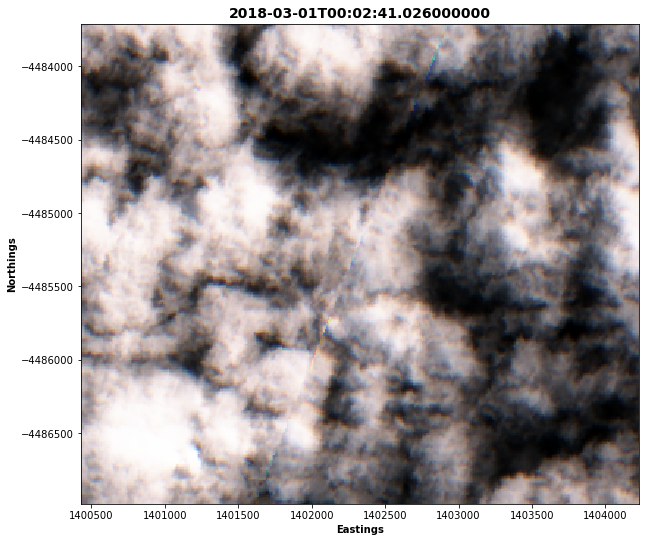

In [5]:
DEAPlotting.three_band_image(data10, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], time = 0, contrast_enhance=True);

In [6]:
'''
datacube.helpers.write_geotiff(
    filename='/g/data1a/r78/DPIPWE_lm/test_burn_mapping/output_data/2017_2018/Sent/s2_LBarron_20180525_20m.tif',
    dataset=data20.isel(time=0))
'''

"\ndatacube.helpers.write_geotiff(\n    filename='/g/data1a/r78/DPIPWE_lm/test_burn_mapping/output_data/2017_2018/Sent/s2_LBarron_20180525_20m.tif',\n    dataset=data20.isel(time=0))\n"

In [7]:
'''
#DEAPlotting.three_band_image(dc_KI, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], time = 0, contrast_enhance=True);
dc_KI.isel(time=0)
'''

"\n#DEAPlotting.three_band_image(dc_KI, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], time = 0, contrast_enhance=True);\ndc_KI.isel(time=0)\n"

In [28]:
# function to return months of interest
def is_cm(month):
    return (month >= 11) | (month <= 4)

In [29]:
# extract just the months of interest
#sent_cm = canberra_cm.sel(time=is_cm(canberra_cm['time.month']))
sent_cm = data10.sel(time=is_cm(data10['time.month']))

In [30]:
sent_cm['time.month']

<xarray.DataArray 'month' (time: 12)>
array([3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4])
Coordinates:
  * time     (time) datetime64[ns] 2018-03-01T00:02:41.026000 ... 2018-04-25T00:02:39.027000

In [31]:
sent_cm

<xarray.Dataset>
Dimensions:      (time: 12, x: 380, y: 327)
Coordinates:
  * y            (y) float64 -4.484e+06 -4.484e+06 ... -4.487e+06 -4.487e+06
  * x            (x) float64 1.4e+06 1.4e+06 1.4e+06 ... 1.404e+06 1.404e+06
  * time         (time) datetime64[ns] 2018-03-01T00:02:41.026000 ... 2018-04-25T00:02:39.027000
Data variables:
    nbart_blue   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbart_green  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbart_red    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nbart_nir_1  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    data_perc    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG:3577

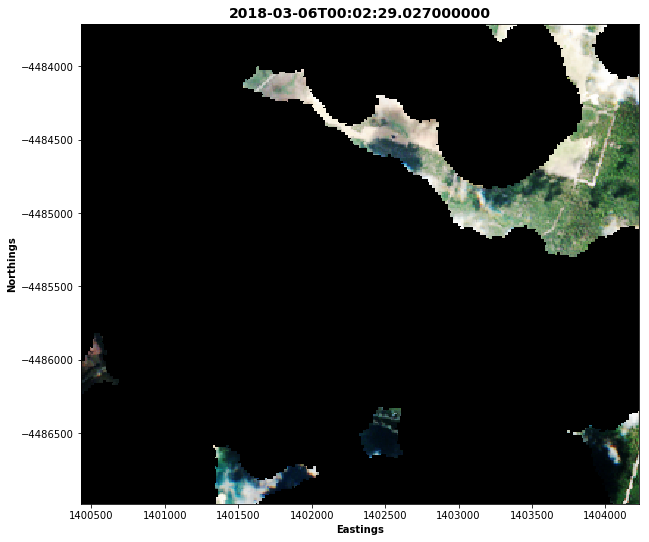

In [32]:
DEAPlotting.three_band_image(sent_cm, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], time = 1, contrast_enhance=True);

In [33]:
sent_cmgm = GeoMedian().compute(sent_cm)

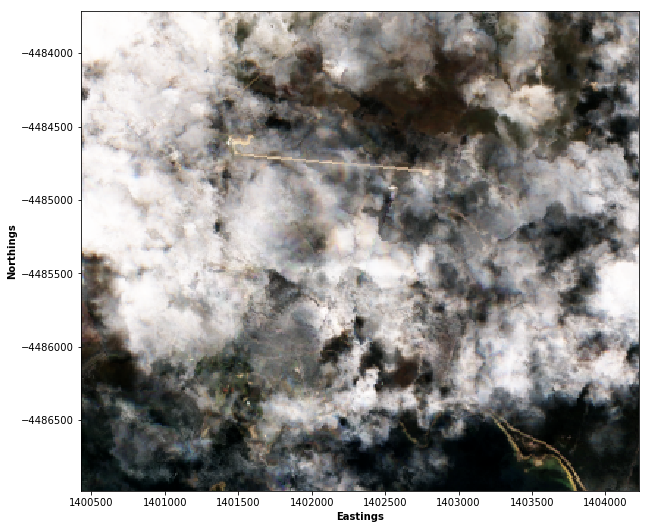

In [24]:
DEAPlotting.three_band_image(sent_cmgm, bands = ['nbart_red', 'nbart_green', 'nbart_blue'], contrast_enhance=True);

In [22]:
#DEADataHandling.dataset_to_geotiff('/g/data/r78/DPIPWE_lm/output_data/KI_S2_nbart_20170630.tif', dc_KI.isel(time=0))
datacube.helpers.write_geotiff(filename='/g/data/r78/DPIPWE_lm/output_data/KI_S2_nbart_20170630.tif', dataset=data.isel(time=0))
#dc.storage.storage.write_dataset_to_netcdf(dc_KI, '/g/data/r78/DPIPWE_lm/output_data/KI_S2_nbart_20170630.tif')